# Project Draft Group 9
Group Member: Xinyu He, Xinrui He

# Github Repository
Data, pretrained model, etc are available on github:  
https://github.com/Xinrui17/PCFBL_team9 

The checkpoints and processed datasets (obtained by step 3) are all included (checkpoints of the models for each sites are in the folders of the sites). Please download all files in github repository for testing or training.  
If you want to test the data processing, please download the orignial datasets via https://drive.google.com/drive/folders/1Q6tegvBtOsy6mBIJW9lc8we1O5LLAWjW?usp=sharing and save them under 'PCFBL_team9' 

This .ipynb file is also included in the /code directory on github. 


## Environment
python3 == 3.9.7  
pytorch == 1.12.1  
pandas == 1.5.3  
matplotlib == 3.8.4  
scikit-learn == 1.4.2

In [1]:
import pandas as pd
import numpy as np
import pickle as pickle
import pickle
pd.options.mode.chained_assignment = None
import re
import pandas as pd
import numpy as np
import pickle as pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
import argparse
import subprocess
import concurrent.futures
from collections import OrderedDict
from sklearn.cluster import KMeans
from joblib import dump, load
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

## 1.Introduction
*   Background of the problem
    * Type of problem  
      Privacy-preserving Personalized Federated Learning in Healthcare.  
    * Importance and Challenges of solving the problem  
      Federated learning support collaborative learning across sites while minimizing privacy concerns. However, federated learning experiences significant performance degradation if the data is non-identically independently distributed (non-IID) across multiple organizations. One possible solution is Clustered FL by clustering patients into groups across hospitals and training separate models on each group. However, this problem is compounded in healthcare settings by privacy concerns, making it challenging to cluster patients into groups based on individual data without exchange of patient-level information, which could lead to inaccurate groups and performance degradation.  
    * State of the art methods and effectiveness
        * CBFL (Community-based Federated Learning): uses K-means clustering on average hospital embeddings. However, this approach uses clustering of hospitals instead of clustering of patients, leading to a sub-optimal performance.
        * FedAvg (Federated Averaging): aggregates model parameters based on sample size in each site. However, it suffers from significant performance degradation if the data is non-IID across multiple organizations.
        * Centralized training (non-federated): does not satisfy the privacy requirement in health setting.
        * Effectiveness (AUC/AUPRC for modality prediction): Centralized > FedAvg $\approx$ CBFL  
*   Paper explanation
    * PCBFL Framework
        * The paper introduces PCBFL, a framework that extends clustered FL by enabling patient clustering using individual-level data while ensuring privacy. It leverages Secure MultiParty Computation (SMPC), a cryptographic technique, for securely calculating patient-level similarity scores across hospitals. This allows for the formation of clinically meaningful patient cohorts without exposing individual patient data, leading to more personalized and effective FL models. The framework is constituted by the following 4 steps:
            1. Creating Patient Embedding    
                Individual patient data are transformed into embeddings using a federated denoising autoencoder. This process generates a compact representation of each patient’s health status without sharing raw data.
            2. Estimating Patient Similarity Securely  
                Using Secure MultiParty Computation (SMPC), PCBFL securely calculates the similarity between patient embeddings across different hospitals. The paper uses a specific SMPC protocol adapted to calculate the dot product between embeddings, which, after normalization, provides a measure of cosine similarity between patients. This step ensures that the computation of patient similarities is done without compromising privacy, as the raw data or embeddings are not exchanged. SMPC protocol works as follows:
               1. Create a dxd invertible matrix $M$ and send $M$ to site1 and $M^{−1}$ to site2 (where d is the embedding dimension)
               2. Each site divides their dataset into submatrices and masks them with $M$ or $M^{−1}$
               3. A limited number of masked submatrices are shared between sites
               4. The submatrices are combined to produce the final dot product without revealing any information about the dataset.
            4. Clustering Patients  
                With similarity scores, patients are then clustered into groups that share similar health profiles. This clustering is performed using a spectral clustering algorithm.
            5. Predicting Mortality  
               The final step involves using the patient clusters to train specialized federated learning models for predicting patient outcomes, such as mortality. Each cluster has a dedicated model trained only on the patients within that cluster. This allows for more personalized models that are tailored to the specific characteristics of each patient group.
    * Innovations: uses SMPC to ensure privacy-preserved patient clustering for federated learning; enables patient-level calculations across different hospitals.
    * Performance: PCBFL outperforms CBFL and FedAvg by AUC and AUPRC. It did not outperforms centralized setting, but given that centralized training does not satisfy privacy requirement, this is acceptable.  
    * Contributions: the first work of using patient clustering for federated learning in healthcare, provides a practical solution to protect patient privacy while enabling patient-level calculations across different hospitals; helps handling non-IID data in healthcare.


<center><img src="framework.png" alt="isolated" width="500"/></center>

## 2.Scope of Reproducibility:

Hypothesis : Performance improvement, PCBFL achieves a statistically significant improvement in
predictive performance (e.g., AUC, AUPRC) for mortality prediction tasks over traditional
Federated Learning (FL) and Clustered Federated Learning (CFL) without patient clustering.


##  3.Data
  * Source of the data: data can be downloaded from the publicly available eICU dataset (https://physionet.org/content/eicu-crd/2.0/)
  * Statistics: Data was randomly split into training and testing datasets in a 70:30 ratio. Since only 20% of the labels were positive, we evaluated performance with both AUC and AUPRC scores. We ran the models for 100 times and calculated the mean scores.
  * Data process: For the different datasets, we first load the data and show the content of the dataset. Then we extract the corresponding features and filter for data in first 48 hours. We have the different filtering details with different datasets.
  * Illustration: we print the first rows of the original datasets and those after preprocessing.

In [2]:
# you need to change the path correspondingly
PATH_DATA = '../'
PATH_SAVE = '../'
PATH = '../'

### 3.1 Load data

In [3]:
patient = pd.read_csv(f'{PATH_DATA}patient.csv.gz')
drugs = pd.read_csv(f'{PATH_DATA}medication.csv.gz')
diagnosis = pd.read_csv(f'{PATH_DATA}diagnosis.csv.gz')
obs = pd.read_csv(f'{PATH_DATA}physicalExam.csv.gz')

C:\Users\HONOR\AppData\Local\Temp\ipykernel_12632\406109537.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  drugs = pd.read_csv(f'{PATH_DATA}medication.csv.gz')


### 3.2 Features

#### Physiologic

In [4]:
def processGCS(df):
    pattern = r'GCS/(\w+)\sScore/(\d+)'
    gcs_y = []
    for entry in df['physicalexampath']:
        match = re.search(pattern, entry)
        if match:
            y_value = match.group(1)
            gcs_y.append(f'GCS_{y_value}')
        else:
            gcs_y.append(f'GCS_total')
    df['physicalexamvalue'] = gcs_y
    return df

In [5]:
##Observations
obs.head()

,physicalexamid,patientunitstayid,physicalexamoffset,physicalexampath,physicalexamvalue,physicalexamtext
0,5253099,176895,9,notes/Progress Notes/Physical Exam/Physical Ex...,scored,scored
1,5253100,176895,9,notes/Progress Notes/Physical Exam/Physical Ex...,Performed - Structured,Performed - Structured
2,5253104,176895,9,notes/Progress Notes/Physical Exam/Physical Ex...,Current,68.3
3,5253105,176895,9,notes/Progress Notes/Physical Exam/Physical Ex...,Intake Total,2725
4,5253106,176895,9,notes/Progress Notes/Physical Exam/Physical Ex...,Output Total,1360


In [6]:
##Extract the physiologic data
pattern = r'^-?\d+$'
#Get GCS
gcs = obs[obs['physicalexampath'].str.contains('GCS')]
gcs_ = gcs[gcs['physicalexamtext'].apply(lambda x: bool(re.match(pattern, str(x))))]
gcs_ = processGCS(gcs_)
gcs_ = gcs_[gcs_['physicalexamvalue'] != 'GCS_total']

#Get Vitals
vs = obs[obs['physicalexampath'].str.contains('Vital Sign')]
vitals = ['HR Current', 'BP (systolic) Current', 'Resp Current', 'O2 Sat% Current']
vs_ = vs[vs['physicalexamvalue'].isin(vitals)]
vs_ = vs_[vs_['physicalexamtext'].apply(lambda x: bool(re.match(pattern, str(x))))]

#Merge
physio = pd.concat([gcs_, vs_])
physio['physicalexamtext'] = physio['physicalexamtext'].astype(int)
physio_ = physio[['patientunitstayid','physicalexamoffset', 'physicalexamvalue', 'physicalexamtext']]
physio_.rename(columns = {'physicalexamvalue':'exam', 'physicalexamtext': 'value'}, inplace = True)

In [7]:
#Filter for data in first 48 hours
MINUTES  = 48*60
physio_ = physio_[physio_['physicalexamoffset'] <= MINUTES]

In [8]:
#Get patients with full coverage
coverage = pd.DataFrame(physio_.groupby('patientunitstayid')['exam'].unique())
coverage['count'] = coverage['exam'].apply(lambda x: len(x))
full_covered = coverage[coverage['count'] == 7]
PIDS_PHYS = list(full_covered.index)

#Filter data for these patients
physio_pts = physio_[physio_['patientunitstayid'].isin(PIDS_PHYS)]

#### Medications

In [9]:
drugs.head()

,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
0,7426715,141168,309,666,No,No,METOPROLOL TARTRATE 25 MG PO TABS,2102.0,25 3,PO,Q12H SCH,NaN,No,1826,0
1,9643232,141168,1847,1832,No,No,3 ML - IPRATROPIUM-ALBUTEROL 0.5-2.5 (3) MG/...,NaN,3 1,NEBULIZATION,Q4H Resp PRN,NaN,Yes,2047,0
2,10270090,141168,296,1386,No,No,ASPIRIN EC 81 MG PO TBEC,1820.0,81 3,PO,Daily,NaN,No,2390,0
3,9496768,141168,2048,2029,No,No,3 ML - IPRATROPIUM-ALBUTEROL 0.5-2.5 (3) MG/...,NaN,3 1,NEBULIZATION,Q4H Resp PRN,NaN,Yes,2390,0
4,11259680,141168,117,246,No,No,ENOXAPARIN SODIUM 40 MG/0.4ML SC SOLN,NaN,40 3,SC,Daily,NaN,No,1721,0


In [10]:
# Filter for drugs administered in the first 48 hours of admit
MINUTES  = 48*60
drugs = drugs[(drugs['drugordercancelled'] == 'No') & (drugs['drugstartoffset'] <= MINUTES)]
drugs_ = drugs[['patientunitstayid' ,'drugname']]
drugs_.dropna(inplace = True)

In [11]:
# Map names to integers
names = list(drugs_['drugname'].unique())
values = [i for i in range(1, len(names)+1)]
mapping = dict(zip(names, values))
mapping_back = dict(zip(values, names))
drugs_['drugid'] = drugs_['drugname'].map(mapping)
drugs_ = drugs_[['patientunitstayid', 'drugid']]

In [12]:
#Extract those with at least 4 medications
PIDS_MED = drugs_.groupby('patientunitstayid').count().loc[lambda x: x['drugid'] >= 4].index.tolist()
drugs_pts = drugs_[drugs_['patientunitstayid'].isin(PIDS_MED)]

#### Diagnosis

In [13]:
def convert_to_4digit_icd9(dxStr):
	if dxStr.startswith('E') != True:
		if len(dxStr) > 5: return dxStr[:5]
		else: return dxStr
	else:
		if len(dxStr) > 6: return dxStr[:6]
		else: return dxStr

In [14]:
diagnosis.head()

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other


In [15]:
#Process codes
dx_codes = diagnosis[['patientunitstayid']]
dx_codes['icd9code'] = diagnosis['icd9code'].str.split(',').str.get(0)
dx_codes.dropna(inplace = True)
dx_codes['icd9code'] = dx_codes['icd9code'].apply(convert_to_4digit_icd9)
#Filter icd9code
pattern = re.compile(r'^\D+')
dx_codes = dx_codes[dx_codes['icd9code'].str.contains(pattern) == False]

In [16]:
#Extract those with at last 4 dx
PIDS_DX = dx_codes.groupby('patientunitstayid').count().loc[lambda x: x['icd9code'] >= 3].index.tolist()
dx_pts = dx_codes[dx_codes['patientunitstayid'].isin(PIDS_DX)]

#### Demographics

In [17]:
patient.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,...,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665


In [18]:
demo = patient[['patientunitstayid', 'age', 'admissionheight', 'admissionweight']]
demo.dropna(inplace = True)
PIDS_DEMO = demo['patientunitstayid'].unique().tolist()

#### Patient intersection of features

In [19]:
PIDS = list(set(PIDS_PHYS).intersection(PIDS_MED).intersection(PIDS_DX).intersection(PIDS_DEMO))
print(f"number of patients with all features: {len(PIDS)}")

number of patients with all features: 44842


In [20]:
patient.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,...,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665


In [21]:
patient_ = patient[patient['patientunitstayid'].isin(PIDS)]
mortality = patient_[['patientunitstayid','patienthealthsystemstayid','hospitalid', 'unitdischargestatus']]
expired = pd.get_dummies(mortality[['unitdischargestatus']])['unitdischargestatus_Expired']
mortality['expired'] = expired
mortality = mortality[['patientunitstayid', 'patienthealthsystemstayid', 'hospitalid', 'expired']]
los = patient_[['patientunitstayid', 'patienthealthsystemstayid', 'hospitalid', 'unitdischargeoffset']]

### 3.3 Patient sampling

In [22]:
##select hospitals with positive cases (otherwise model fails)
def get_hospitals(unique_pt, TOTAL = 250, POS = 50):
    grouped_pt = unique_pt.groupby(['hospitalid', 'expired']).agg({'patienthealthsystemstayid': 'count'})
    pos_h = grouped_pt.loc[grouped_pt.index.get_level_values('expired') == 1][
        grouped_pt.loc[grouped_pt.index.get_level_values('expired') == 1, 'patienthealthsystemstayid'] >= POS
        ].index.get_level_values('hospitalid')
    neg_h =   grouped_pt.loc[grouped_pt.index.get_level_values('expired') == 0][
        grouped_pt.loc[grouped_pt.index.get_level_values('expired') == 0, 'patienthealthsystemstayid'] >= TOTAL - POS
        ].index.get_level_values('hospitalid')

    hospitals = list(set(neg_h).intersection(set(pos_h)))
    return hospitals

In [23]:
def sample_group(group, TOTAL = 250, POS = 50):
    expired_1 = group[group['expired'] == 1]
    expired_0 = group[group['expired'] == 0]
    n_expired_1 = POS
    n_expired_0 = TOTAL-POS
    sample_expired_1 = expired_1.sample(n=n_expired_1, random_state=1)
    sample_expired_0 = expired_0.sample(n=n_expired_0, random_state=1)
    samples = pd.concat([sample_expired_1, sample_expired_0])
    return samples.sample(frac=1, random_state=1)

In [24]:
# Select the first stay for a patient
outcome = mortality.merge(los[['patientunitstayid', 'unitdischargeoffset']], on = 'patientunitstayid')
outcome = outcome.groupby('patienthealthsystemstayid').min('unitdischargeoffset').reset_index()

In [25]:
# Filter hosptials 100 positive patients and 300 overall
unique_pt = outcome[['hospitalid','patienthealthsystemstayid', 'patientunitstayid', 'expired']]
hosp_counts = unique_pt.groupby('hospitalid').count()[['patienthealthsystemstayid']]
hospitals = get_hospitals(unique_pt)
hosp_pts = unique_pt[unique_pt['hospitalid'].isin(hospitals)]
print(f"number of hospitals: {hosp_pts['hospitalid'].nunique()}, number of patients: {hosp_pts['patientunitstayid'].nunique()}")

number of hospitals: 20, number of patients: 20221


In [26]:
# For each hospital randomly sample 300 patients
selected_patients = hosp_pts.groupby('hospitalid').apply(sample_group)
selected_patients.reset_index(level=0, drop = True, inplace = True)

### 3.4 Filter datasets

In [27]:
# Filter patients in datasets
##mortality
mortality_final = mortality[mortality['patientunitstayid'].isin(selected_patients['patientunitstayid'])]
##los
los_final = los[los['patientunitstayid'].isin(selected_patients['patientunitstayid'])]
##features
demo_final = demo[demo['patientunitstayid'].isin(selected_patients['patientunitstayid'])]
dx_final = dx_pts[dx_pts['patientunitstayid'].isin(selected_patients['patientunitstayid'])]
drugs_final = drugs_pts[drugs_pts['patientunitstayid'].isin(selected_patients['patientunitstayid'])]
physio_final = physio_pts[physio_pts['patientunitstayid'].isin(selected_patients['patientunitstayid'])]

In [28]:
#Check PIDS are equal
patients_included = []
for df in [demo_final, dx_final, drugs_final, physio_final, mortality_final, los_final]:
    patients_included.append(df['patientunitstayid'].nunique())
len(set(patients_included)) == 1

True

In [29]:
#Sample sizes
sample_size = selected_patients.groupby('hospitalid')[['patientunitstayid']].count()
sample_size.columns = ['count']
sample_size.to_csv(f'{PATH_SAVE}hospitals.csv')

### 3.5 Prcoess datasets for analysis

In [30]:
def add_hospid(df, hosp):
    return df.merge(hosp[['patientunitstayid', 'hospitalid']], on = 'patientunitstayid')

demo_final = add_hospid(demo_final, mortality)
dx_final = add_hospid(dx_final, mortality)
drugs_final = add_hospid(drugs_final, mortality)
physio_final = add_hospid(physio_final, mortality)

In [31]:
#Map features to integers for model
def map_codes_integers(df, column):
    names = list(df[column].unique())
    values = [i for i in range(1, len(names)+1)]
    mapping = dict(zip(names, values))
    column_new = f'{column}id'
    df[column_new] = df[column].map(mapping)
    return mapping, df.drop(columns = column)

dx_mapping, dx_final_ = map_codes_integers(dx_final, 'icd9code')
physio_mapping, physio_final_ = map_codes_integers(physio_final, 'exam')


In [32]:
#Create pivot tables
drugs_p = drugs_final[['patientunitstayid', 'drugid']].pivot_table(index='patientunitstayid', columns='drugid', aggfunc=lambda x: x['drugid'].count(), fill_value=0)
dx_p = dx_final[['patientunitstayid', 'icd9codeid']].pivot_table(index='patientunitstayid', columns='icd9codeid', aggfunc=lambda x: x['icd9codeid'].count(), fill_value=0)
physio_p = physio_final[['patientunitstayid', 'examid', 'value']].pivot_table(index='patientunitstayid', columns='examid', values='value')

### 3.6 Save

In [33]:
dataframes = [(mortality_final, 'mortality', False), 
              (los_final, 'los', False), 
              (dx_p, 'diagnosis', True), 
              (drugs_p, 'medications', True), 
              (physio_p, 'physio', True), 
              (demo_final, 'demographics', False),
              (dx_final, 'diagnosis_raw', False), 
              (drugs_final, 'medications_raw', False), 
              (physio_final, 'physio_raw', False)]
#All
for df, filename, index in dataframes:
    df.to_csv(f'{PATH_SAVE}{filename}.csv', index=index)

In [34]:
import os
dataframes = [(mortality_final, 'mortality', False), 
              (los_final, 'los', False), 
              (dx_p, 'diagnosis', True), 
              (drugs_p, 'medications', True), 
              (physio_p, 'physio', True), 
              (demo_final, 'demographics', False)]
#Hospital
for hosp in hospitals:
    for df, filename, index in dataframes:
        if filename in ['diagnosis', 'medications', 'physio']:
            df_ = df.merge(mortality_final[['patientunitstayid', 'hospitalid']], left_index = True, right_on = 'patientunitstayid')
            df_ = df_[df_['hospitalid'] == hosp]
            df_hosp = df_.drop('hospitalid', axis = 1).set_index('patientunitstayid')
        else:
            df_hosp = df[df['hospitalid'] == hosp]
        path_to_save = f'{PATH_SAVE}{hosp}/{filename}.csv'
        directory = os.path.dirname(path_to_save)
        if not os.path.exists(directory):  
            os.makedirs(directory)  
        df_hosp.to_csv(path_to_save, index=index)
#         df_hosp.to_csv(path_to_save, index=index)

In [35]:
with open(f'{PATH_SAVE}drug_map.pickle', 'wb') as file:
    pickle.dump(mapping, file)

with open(f'{PATH_SAVE}code_icd_map.pickle', 'wb') as file:
    pickle.dump(dx_mapping, file)

with open(f'{PATH_SAVE}physio_map.pickle', 'wb') as file:
    pickle.dump(physio_mapping, file)

##   4.Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type (input dim -> output dim), activation function, etc
      * AutoEncoder for patient embedding:
          1. Encoder:
              * Linear: input_dim -> input_dim//4
              * Activation: ReLU
              * Linear: input_dim//4 -> input_dim//6
              * Activation: ReLU
              * Linear: input_dim//6 -> 12
          2. Decoder:
              * Linear: 12 -> input_dim//6
              * Activation: ReLU
              * Linear: input_dim//6 -> input_dim//4
              * Activation: ReLU
              * Linear: input_dim//4 -> input_dim
              * Activation: Sigmoid
       * FeedForward module for prediction:
           1. Three encoders for physical exam, diagnosis, and medication respectively. Each encoder is composed of
              * Linear: input_dim -> 100 (40 for physio)
              * Activation: ReLU
              * Linear: 100 -> 50 (40 -> 20 for physio)
              * Activation: ReLU
              * Linear: 50 -> 10 (20 -> 10 for physio)
              * Activation: ReLU
              * Linear: 10 -> 5
           2. Three embeddings are then concatenated into a length 15 embedding for further encoding and prediction
              * Linear: 15 -> 15
              * Activation: ReLU
              * Linear: 15 -> 10
              * Activation: ReLU
              * Linear: 10 -> 5
              * Activation: ReLU
              * Linear: 5 -> 1
              * Activation: Sigmoid
  * Training objectives: BCE Loss is used for training prediction model, MSE Loss is used for training AutoEncoder. Adam optimizers are applied for both models. Training samples are assigned with equal weights.

## 5. Training
### Hyperparameter list
* Learning rate: 1e-3  
* Batch size: 32  
* Number of clusters: 3
* Embedding size: 36
### Computation Requirements
* Hardware:
    * CPU: Intel(R) Xeon(R) Gold 6240R CPU @ 2.40GHz
    * GPU: Tesla V100
* Total number of trials: 5
* Training rounds: 20  
* Epochs per round: 10

In [36]:
global MODELTYPE
global PATH
PATH = '../'
PATH_DATA = '../'
PATH_FL_SCRIPT = ''
FT_TYPES = ['meds', 'dx', 'physio']
DIMS = {'meds':1056, 'dx':483, 'physio': 7}
HOSPITALS=[264,142,148,281,154,283,157,420,165,167,176,449,79,199,458,338,227,248,122,252]
N_CLUSTERS = 3
MODELTYPE = "p_cbfl"

class FeedForward(nn.Module):
    def __init__(self, input_dim_drugs, input_dim_dx, input_dim_physio):
        super().__init__()
        
        self.input_dim_drugs = input_dim_drugs
        self.input_dim_dx = input_dim_dx
        self.input_dim_physio = input_dim_physio

        
        self.FF_meds = nn.Sequential(
                        nn.Linear(self.input_dim_drugs, 100),
                        nn.ReLU(),
                        nn.Linear(100, 50),
                        nn.ReLU(),
                        nn.Linear(50, 10),
                        nn.ReLU(),
                        nn.Linear(10, 5)
                        )
        
        self.FF_dx = nn.Sequential(
                        nn.Linear(self.input_dim_dx, 100),
                        nn.ReLU(),
                        nn.Linear(100, 50),
                        nn.ReLU(),
                        nn.Linear(50, 10),
                        nn.ReLU(),
                        nn.Linear(10, 5)
                        )
        
        self.FF_physio = nn.Sequential(
                        nn.Linear(self.input_dim_physio, 40),
                        nn.ReLU(),
                        nn.Linear(40, 20),
                        nn.ReLU(),
                        nn.Linear(20, 10),
                        nn.ReLU(),
                        nn.Linear(10, 5)
                        )
        
        self.FF_multihead = nn.Sequential(
                        nn.Linear(15, 15),
                        nn.ReLU(),
                        nn.Linear(15, 10),
                        nn.ReLU(),
                        nn.Linear(10, 5),
                        nn.ReLU(),
                        nn.Linear(5, 1),
                        nn.Sigmoid()
                        )

    def forward(self, x_drugs, x_dx, x_physio):
        meds = self.FF_meds(x_drugs)
        dx =  self.FF_dx(x_dx)
        physio = self.FF_physio(x_physio)
        ##concatentate
        x_concat = torch.cat((meds, dx, physio), dim = 1)
        #run through final head
        scores = self.FF_multihead(x_concat)
        return scores

#FEDAVG
def FedAvg(hospitals, global_model, model):
    # Load the state dicts for each hospital model and set them to eval mode
    hospital_params_list = []
    hosps_included = []
    try: 
        for i, hosp in enumerate(hospitals.index):
            hospital_params = torch.load(f'{PATH}{hosp}/{model}.pt')
            hospital_params_list.append(hospital_params)
            hosps_included.append(hosp)
    except:
        # if site doesnt have cluster
        pass
    
    # Set the weights for each hospital
    weights = hospitals.loc[hosps_included]['weight'].values
    
    # Compute the weighted average of the model parameters
    global_params = OrderedDict()
    for key in hospital_params_list[0]:
        global_params[key] = torch.zeros(hospital_params_list[0][key].shape)
    
    for i, hospital_params in enumerate(hospital_params_list):
        for key in hospital_params:
            global_params[key] += hospital_params[key] * weights[i]
    
    # Set the global model parameters to the averaged parameters
    global_model.load_state_dict(global_params)
    return global_model

def runFedAvg(hospitals, model, mode):
    # run for each cluster
    if mode == 'all':
        dim0, dim1, dim2 = list(DIMS.values())
        global_model = FeedForward(dim0, dim1, dim2)
        model = f'prediction'
        global_model = FedAvg(hospitals, global_model, model)
        return global_model
    
    elif mode == 'cluster':
        global_models = {}
        for i in range(N_CLUSTERS):
            dim0, dim1, dim2 = list(DIMS.values())
            global_model = FeedForward(dim0, dim1, dim2)
            model = f'prediction_cluster_{i}'
            hospitals_cluster = calc_weights(PATH, hospitals, i)
            global_model = FedAvg(hospitals_cluster, global_model, model)
            global_models[i] = global_model
        return global_models


#weight input by cluster size
def load_cluster_weights(PATH, hosp):
    cluster = pd.read_csv(f'{PATH}{hosp}/clusters.csv')
    cluster_weights = cluster.value_counts('cluster')
    cluster_df = pd.DataFrame(cluster_weights, columns = ['count'])
    cluster_df['site'] = hosp
    cluster_df.reset_index(inplace = True)
    return cluster_df

def site_weight(row):
    row['weight'] = row['count'] / row['count'].sum()
    return row

def calc_weights(PATH, hospitals, cluster):
    cluster_sizes = pd.DataFrame()
    for hosp in HOSPITALS:
        c = load_cluster_weights(PATH, hosp)
        cluster_sizes = pd.concat([cluster_sizes, c])
    cluster_sizes = cluster_sizes.groupby('cluster').apply(site_weight)
    cluster_filter = cluster_sizes[cluster_sizes['cluster']==cluster]
    hospitals_cluster = hospitals[[]].merge(cluster_filter[['count', 'site', 'weight']], left_index = True, right_on='site')
    hospitals_cluster.set_index('site', inplace = True)
    return hospitals_cluster


        
#COORDINATION
def clear_clients(hosp, model):
    ##clear models from clients
    command = f'rm {PATH}{hosp}/{model}.pt ' 
    subprocess.call(command, shell = True)
    return

def run_clients(hosp, model, run, task = None):
    command = f'python {PATH_FL_SCRIPT}client_{model}.py -cl={hosp} -rn={run} -tk={task} -mt={MODELTYPE}'
    command = command.split(' ')
    output = subprocess.check_output(command) 
    server_response = output.decode('utf-8').split(' ')
    return server_response

def run_private_clustering(MODELTYPE):
    #run private clustering
    command = f'python {PATH_FL_SCRIPT}server_private.py -mt={MODELTYPE}'
    command = command.split(' ')
    output = subprocess.check_output(command) 
    server_response = output.decode('utf-8').split(' ')
    return server_response

def run_prediction(hospitals, iteration, MODE):
    #########PREDICTION TASK#########
    MODEL = 'prediction'
    TASK = 'mortality'
    ROUNDS = 15
    
    ##Initialize model for each cluster
    dim0, dim1, dim2 = list(DIMS.values())
    initial_model = FeedForward(dim0, dim1, dim2)
    for hosp in hospitals.index:
        site_clusters = np.loadtxt(f'{PATH}{hosp}/site_clusters', dtype = int)
        site_clusters = np.atleast_1d(site_clusters)
        for i in site_clusters:
            torch.save(initial_model.state_dict(), f'{PATH}{hosp}/{MODEL}_cluster_{i}.pt')

            
    ##Run prediction models for multiple rounds
    for i in range(ROUNDS):
        RUN = 'train'
        futures = []
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for hosp in hospitals.index:
                futures.append(executor.submit(run_clients,hosp, MODEL, RUN))
        concurrent.futures.wait(futures)

        ##Average
        global_models = runFedAvg(hospitals, MODEL, MODE)
        #save
        for hosp in hospitals.index:
            site_clusters = np.loadtxt(f'{PATH}{hosp}/site_clusters', dtype = int)
            site_clusters = np.atleast_1d(site_clusters)
            for i in site_clusters:
                global_model = global_models[i]
                torch.save(global_model.state_dict(), f'{PATH}{hosp}/prediction_cluster_{i}.pt') 

   ##After training save global model for inference
    for hosp in hospitals.index:
        site_clusters = np.loadtxt(f'{PATH}{hosp}/site_clusters', dtype = int)
        site_clusters = np.atleast_1d(site_clusters)
        for i in site_clusters:
            global_model = global_models[i]
            torch.save(global_model.state_dict(), f'{PATH}{hosp}/global_prediction_cluster_{i}.pt') 

    ##Inference   
    RUN = 'test'
    futures = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for hosp in hospitals.index:
            futures.append(executor.submit(run_clients,hosp, MODEL, RUN))
    concurrent.futures.wait(futures)

    ##Get reuslts
    results = pd.DataFrame(columns = ['cluster', 'AUC', 'site'])
    results_auprc = pd.DataFrame(columns = ['cluster', 'AUPRC', 'site'])
    for hosp in hospitals.index:
        result_site = pd.read_csv( f'{PATH}{hosp}/results.csv')
        result_site_auprc = pd.read_csv( f'{PATH}{hosp}/results_auprc.csv')
        result_site['site'] = hosp
        result_site_auprc['site'] = hosp
        results = pd.concat([results, result_site])
        results_auprc = pd.concat([results_auprc, result_site_auprc])

    ## Check if the average AUC is less than or equal to 0.5 i.e. wehther model learned
    if results['AUC'].mean() <= 0.5:
        print("Average AUC is less than or equal to 0.5. Rerunning the function...")
        return run_prediction(hospitals, iteration, MODE)
    else:
        ##Save results
        results.to_csv(f'{PATH}{TASK}_results_{iteration}.csv', index = False)
        results_auprc.to_csv(f'{PATH}{TASK}_results_auprc_{iteration}.csv', index = False)
        return


def run_prediction_avg(hospitals, iteration, MODE):
        #########PREDICTION TASK#########
    MODEL = 'prediction'
    TASK = 'mortality'
    ROUNDS = 15
    
    ##Initialize model for each cluster
    dim0, dim1, dim2 = list(DIMS.values())
    initial_model = FeedForward(dim0, dim1, dim2)
    for hosp in hospitals.index:
        torch.save(initial_model.state_dict(), f'{PATH}{hosp}/{MODEL}.pt')

            
    ##Run prediction models for multiple rounds
    for i in range(ROUNDS):
        RUN = 'train'
        futures = []
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for hosp in hospitals.index:
                futures.append(executor.submit(run_clients,hosp, MODEL, RUN))
        concurrent.futures.wait(futures)

        ##Average
        global_model = runFedAvg(hospitals, MODEL, MODE)
        #save
        for hosp in hospitals.index:
            torch.save(global_model.state_dict(), f'{PATH}{hosp}/prediction.pt') 

   ##After training save global model for inference
    for hosp in hospitals.index:
        torch.save(global_model.state_dict(), f'{PATH}{hosp}/global_prediction.pt') 

    ##Inference   
    RUN = 'test'
    futures = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for hosp in hospitals.index:
            futures.append(executor.submit(run_clients,hosp, MODEL, RUN))
    concurrent.futures.wait(futures)

    ##Get reuslts
    results = pd.DataFrame(columns = ['site', 'AUC'])
    results_auprc = pd.DataFrame(columns = ['site', 'AUPRC'])
    for hosp in hospitals.index:
        result_site = pd.read_csv( f'{PATH}{hosp}/results.csv')
        result_site_auprc = pd.read_csv( f'{PATH}{hosp}/results_auprc.csv')
        results = pd.concat([results, result_site])
        results_auprc = pd.concat([results_auprc, result_site_auprc])

    ## Check if the average AUC is less than or equal to 0.5 i.e. wehther model learned
    if results['AUC'].mean() <= 0.5:
        print("Average AUC is less than or equal to 0.5. Rerunning the function...")
        if MODELTYPE == 'avg':
            return run_prediction_avg(hospitals, iteration, MODE)
        else:
            return run_prediction(hospitals, iteration, MODE)
    else:
        ##Save results
        results.to_csv(f'{PATH}{TASK}_{MODELTYPE}_results_{iteration}.csv', index = False)
        results_auprc.to_csv(f'{PATH}{TASK}_{MODELTYPE}_results_auprc_{iteration}.csv', index = False)
        return

def main(iteration):
    #Load hospitals
    hospitals = pd.read_csv(f'{PATH_DATA}hospitals.csv', index_col = 'hospitalid')

    if MODELTYPE  == 'cbfl':
        MODE = 'cluster'
        run_prediction(hospitals, iteration, MODE)
    else:
        if (MODELTYPE  == 'emb') | (MODELTYPE  == 'p_cbfl'):
            # run_private_clustering(MODELTYPE)
            MODE = 'cluster'
            run_prediction(hospitals, iteration, MODE)
        elif MODELTYPE == 'avg':
            hospitals['weight'] = hospitals['count'] / hospitals['count'].sum()
            MODE = 'all'
            run_prediction_avg(hospitals, iteration, MODE)    


    

#### Evaluation of the model p_cfbl  
The Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC) curve represents the likelihood that the model ranks a random positive example more highly than a random negative example.  
The Area Under the Precision-Recall Curve (AUPRC) measures the performance of binary classification models, particularly in scenarios where there is a significant class imbalance. It plots precision (the proportion of true positives among positive predictions) against recall (the proportion of true positives among actual positives) across different thresholds.  
To calculate the overall AUC and AUPRC (Global R) for CBFL and PCBFL, the paper uses a weighted average of results that takes into account the number of patients each site contributes to a cluster.


In [37]:
global PATH
PATH = '../'
    
#main(0)
results_path = '../mortality_results_0.csv'
results_df = pd.read_csv(results_path)
results_df_cleaned = results_df.dropna(subset=['AUC'])
cluster_weights = results_df_cleaned.groupby(['site', 'cluster']).size().reset_index(name='count')
total_counts = cluster_weights.groupby('site')['count'].sum().reset_index(name='total_count')
cluster_weights = cluster_weights.merge(total_counts, on='site')
cluster_weights['weight'] = cluster_weights['count'] / cluster_weights['total_count']
merged_df = results_df_cleaned.merge(cluster_weights, on=['site', 'cluster'])
# Multiply each AUC by its weight and sum the products to get the numerator for Global R
weighted_auc_sum = (merged_df['AUC'] * merged_df['weight']).sum()
# The denominator N is the sum of all weights
N = cluster_weights['weight'].sum()
global_r_weighted = weighted_auc_sum / N
print(global_r_weighted)


0.7230271797653275


In [38]:
# AUPRC
results_path = '../mortality_results_auprc_0.csv'
results_df = pd.read_csv(results_path)
results_df_cleaned = results_df.dropna(subset=['AUPRC'])
cluster_weights = results_df_cleaned.groupby(['site', 'cluster']).size().reset_index(name='count')
total_counts = cluster_weights.groupby('site')['count'].sum().reset_index(name='total_count')
cluster_weights = cluster_weights.merge(total_counts, on='site')
cluster_weights['weight'] = cluster_weights['count'] / cluster_weights['total_count']
merged_df = results_df_cleaned.merge(cluster_weights, on=['site', 'cluster'])
# Multiply each AUPRC by its weight and sum the products to get the numerator for Global R
weighted_auc_sum = (merged_df['AUPRC'] * merged_df['weight']).sum()
# The denominator N is the sum of all weights
N = cluster_weights['weight'].sum()
global_r_weighted = weighted_auc_sum / N
print(global_r_weighted)



0.5566002809092587


### Results

#### Compared to traditional federated learning model FedAvg

In [39]:
global PATH
MODELTYPE = "avg"
PATH = '../'
#main(93)
results_path = '../mortality_prediction_results_93.csv'
results_df = pd.read_csv(results_path)
global_r = results_df['AUC'].mean(skipna=True)
print(global_r)

0.5741788666421009


In [40]:
global PATH
MODELTYPE = "avg"
PATH = '../'
#main(93)
results_path = '../mortality_prediction_results_auprc_93.csv'
results_df = pd.read_csv(results_path)
global_r = results_df['AUPRC'].mean(skipna=True)
print(global_r)

0.4156562011933755


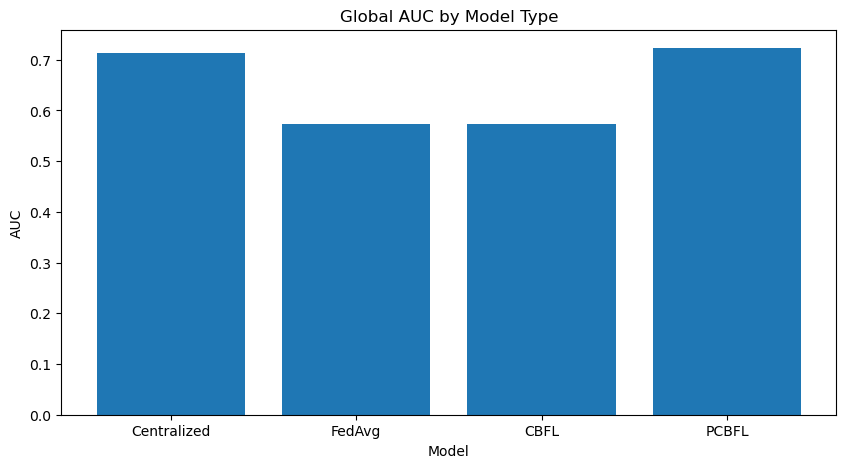

In [41]:
# results  AUC
categories = ['Centralized', 'FedAvg', 'CBFL', 'PCBFL']  
values = [0.7133, 0.5742, 0.5732, 0.7230]  
  
plt.figure(figsize=(10, 5))  
plt.bar(categories, values)  
plt.title('Global AUC by Model Type')  
plt.xlabel('Model')  
plt.ylabel('AUC')    
plt.show()

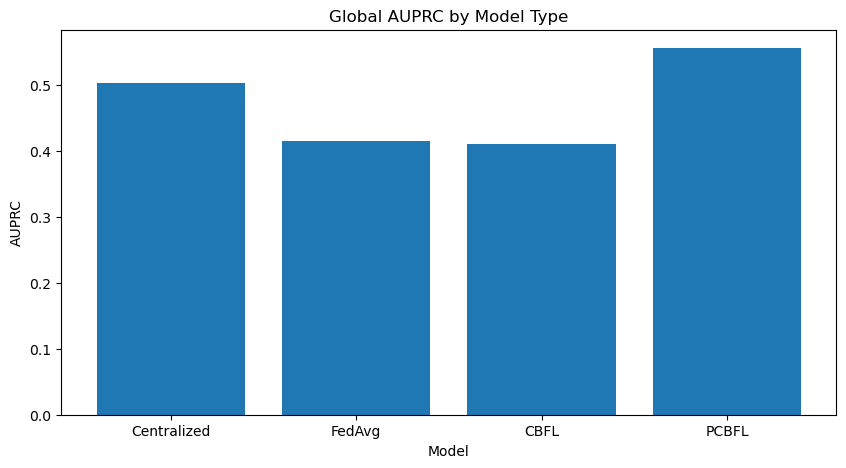

In [42]:

# results  
categories = ['Centralized', 'FedAvg', 'CBFL', 'PCBFL']  
values = [0.5034, 0.4156, 0.4111, 0.5566]  
plt.figure(figsize=(10, 5))  
plt.bar(categories, values)  
plt.title('Global AUPRC by Model Type')  
plt.xlabel('Model')  
plt.ylabel('AUPRC')    
plt.show()

## 6. Ablation Study

### Ablation study of patient embedding learning  
To study whether the autoencoder in framework effectively capture latent information of patients’
EHRs and whether the learned latent information helps with clustering, we conduct ablation
study by removing the autoencoder, i.e., to replace the learned embeddings with normalized raw
features for similarity estimation.


In [43]:
SUFFIX = '_raw'

In [44]:
#FEDAVG
def FedAvg(hospitals, global_model, model):
    # Load the state dicts for each hospital model and set them to eval mode
    hospital_params_list = []
    hosps_included = []
    try: 
        for i, hosp in enumerate(hospitals.index):
            hospital_params = torch.load(f'{PATH}{hosp}/{model}_{SUFFIX}.pt')
            hospital_params_list.append(hospital_params)
            hosps_included.append(hosp)
    except:
        # if site doesnt have cluster
        pass
    
    # Set the weights for each hospital
    weights = hospitals.loc[hosps_included]['weight'].values
    
    # Compute the weighted average of the model parameters
    global_params = OrderedDict()
    for key in hospital_params_list[0]:
        global_params[key] = torch.zeros(hospital_params_list[0][key].shape)
    
    for i, hospital_params in enumerate(hospital_params_list):
        for key in hospital_params:
            global_params[key] += hospital_params[key] * weights[i]
    
    # Set the global model parameters to the averaged parameters
    global_model.load_state_dict(global_params)
    return global_model

def runFedAvg(hospitals, model, mode):
    # run for each cluster
    if mode == 'all':
        dim0, dim1, dim2 = list(DIMS.values())
        global_model = FeedForward(dim0, dim1, dim2)
        model = f'prediction'
        global_model = FedAvg(hospitals, global_model, model)
        return global_model
    
    elif mode == 'cluster':
        global_models = {}
        for i in range(N_CLUSTERS):
            dim0, dim1, dim2 = list(DIMS.values())
            global_model = FeedForward(dim0, dim1, dim2)
            model = f'prediction_cluster_{i}'
            hospitals_cluster = calc_weights(PATH, hospitals, i)
            global_model = FedAvg(hospitals_cluster, global_model, model)
            global_models[i] = global_model
        return global_models


#weight input by cluster size
def load_cluster_weights(PATH, hosp):
    cluster = pd.read_csv(f'{PATH}{hosp}/clusters_{SUFFIX}.csv')
    cluster_weights = cluster.value_counts('cluster')
    cluster_df = pd.DataFrame(cluster_weights, columns = ['count'])
    cluster_df['site'] = hosp
    cluster_df.reset_index(inplace = True)
    return cluster_df

def site_weight(row):
    row['weight'] = row['count'] / row['count'].sum()
    return row

def calc_weights(PATH, hospitals, cluster):
    cluster_sizes = pd.DataFrame()
    for hosp in HOSPITALS:
        c = load_cluster_weights(PATH, hosp)
        cluster_sizes = pd.concat([cluster_sizes, c])
    cluster_sizes = cluster_sizes.groupby('cluster').apply(site_weight)
    cluster_filter = cluster_sizes[cluster_sizes['cluster']==cluster]
    hospitals_cluster = hospitals[[]].merge(cluster_filter[['count', 'site', 'weight']], left_index = True, right_on='site')
    hospitals_cluster.set_index('site', inplace = True)
    return hospitals_cluster


        
#COORDINATION
def clear_clients(hosp, model):
    ##clear models from clients
    command = f'rm {PATH}{hosp}/{model}.pt ' 
    subprocess.call(command, shell = True)
    return

def run_clients(hosp, model, run, task = None):
    command = f'python {PATH_FL_SCRIPT}client_{model}.py -cl={hosp} -rn={run} -tk={task} -mt={MODELTYPE}'
    command = command.split(' ')
    output = subprocess.check_output(command) 
    server_response = output.decode('utf-8').split(' ')
    return server_response

def run_private_clustering(MODELTYPE):
    #run private clustering
    command = f'python {PATH_FL_SCRIPT}server_private.py -mt={MODELTYPE}'
    command = command.split(' ')
    output = subprocess.check_output(command) 
    server_response = output.decode('utf-8').split(' ')
    return server_response

def run_prediction(hospitals, iteration, MODE):
    #########PREDICTION TASK#########
    MODEL = 'prediction'
    TASK = 'mortality'
    ROUNDS = 15
    
    ##Initialize model for each cluster
    dim0, dim1, dim2 = list(DIMS.values())
    initial_model = FeedForward(dim0, dim1, dim2)
    for hosp in hospitals.index:
        site_clusters = np.loadtxt(f'{PATH}{hosp}/site_clusters_{SUFFIX}', dtype = int)
        site_clusters = np.atleast_1d(site_clusters)
        for i in site_clusters:
            torch.save(initial_model.state_dict(), f'{PATH}{hosp}/{MODEL}_cluster_{i}_{SUFFIX}.pt')

            
    ##Run prediction models for multiple rounds
    for i in range(ROUNDS):
        RUN = 'train'
        futures = []
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for hosp in hospitals.index:
                futures.append(executor.submit(run_clients,hosp, MODEL, RUN))
        concurrent.futures.wait(futures)

        ##Average
        global_models = runFedAvg(hospitals, MODEL, MODE)
        #save
        for hosp in hospitals.index:
            site_clusters = np.loadtxt(f'{PATH}{hosp}/site_clusters_{SUFFIX}', dtype = int)
            site_clusters = np.atleast_1d(site_clusters)
            for i in site_clusters:
                global_model = global_models[i]
                torch.save(global_model.state_dict(), f'{PATH}{hosp}/prediction_cluster_{i}_{SUFFIX}.pt') 

   ##After training save global model for inference
    for hosp in hospitals.index:
        site_clusters = np.loadtxt(f'{PATH}{hosp}/site_clusters_{SUFFIX}', dtype = int)
        site_clusters = np.atleast_1d(site_clusters)
        for i in site_clusters:
            global_model = global_models[i]
            torch.save(global_model.state_dict(), f'{PATH}{hosp}/global_prediction_cluster_{i}_{SUFFIX}.pt') 

    ##Inference   
    RUN = 'test'
    futures = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for hosp in hospitals.index:
            futures.append(executor.submit(run_clients,hosp, MODEL, RUN))
    concurrent.futures.wait(futures)

    ##Get reuslts
    results = pd.DataFrame(columns = ['cluster', 'AUC', 'site'])
    results_auprc = pd.DataFrame(columns = ['cluster', 'AUPRC', 'site'])
    for hosp in hospitals.index:
        result_site = pd.read_csv( f'{PATH}{hosp}/results_{SUFFIX}.csv')
        result_site_auprc = pd.read_csv( f'{PATH}{hosp}/results_auprc_{SUFFIX}.csv')
        result_site['site'] = hosp
        result_site_auprc['site'] = hosp
        results = pd.concat([results, result_site])
        results_auprc = pd.concat([results_auprc, result_site_auprc])

    ## Check if the average AUC is less than or equal to 0.5 i.e. wehther model learned
    if results['AUC'].mean() <= 0.5:
        print("Average AUC is less than or equal to 0.5. Rerunning the function...")
        return run_prediction(hospitals, iteration, MODE)
    else:
        ##Save results
        results.to_csv(f'{PATH}{TASK}_results_{iteration}_{SUFFIX}.csv', index = False)
        results_auprc.to_csv(f'{PATH}{TASK}_results_auprc_{iteration}_{SUFFIX}.csv', index = False)
        return


def run_prediction_avg(hospitals, iteration, MODE):
        #########PREDICTION TASK#########
    MODEL = 'prediction'
    TASK = 'mortality'
    ROUNDS = 15
    
    ##Initialize model for each cluster
    dim0, dim1, dim2 = list(DIMS.values())
    initial_model = FeedForward(dim0, dim1, dim2)
    for hosp in hospitals.index:
        torch.save(initial_model.state_dict(), f'{PATH}{hosp}/{MODEL}_{SUFFIX}.pt')

            
    ##Run prediction models for multiple rounds
    for i in range(ROUNDS):
        RUN = 'train'
        futures = []
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for hosp in hospitals.index:
                futures.append(executor.submit(run_clients,hosp, MODEL, RUN))
        concurrent.futures.wait(futures)

        ##Average
        global_model = runFedAvg(hospitals, MODEL, MODE)
        #save
        for hosp in hospitals.index:
            torch.save(global_model.state_dict(), f'{PATH}{hosp}/prediction_{SUFFIX}.pt') 

   ##After training save global model for inference
    for hosp in hospitals.index:
        torch.save(global_model.state_dict(), f'{PATH}{hosp}/global_prediction_{SUFFIX}.pt') 

    ##Inference   
    RUN = 'test'
    futures = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for hosp in hospitals.index:
            futures.append(executor.submit(run_clients,hosp, MODEL, RUN))
    concurrent.futures.wait(futures)

    ##Get reuslts
    results = pd.DataFrame(columns = ['site', 'AUC'])
    results_auprc = pd.DataFrame(columns = ['site', 'AUPRC'])
    for hosp in hospitals.index:
        result_site = pd.read_csv( f'{PATH}{hosp}/results_{SUFFIX}.csv')
        result_site_auprc = pd.read_csv( f'{PATH}{hosp}/results_auprc_{SUFFIX}.csv')
        results = pd.concat([results, result_site])
        results_auprc = pd.concat([results_auprc, result_site_auprc])

    ## Check if the average AUC is less than or equal to 0.5 i.e. wehther model learned
    if results['AUC'].mean() <= 0.5:
        print("Average AUC is less than or equal to 0.5. Rerunning the function...")
        if MODELTYPE == 'avg':
            return run_prediction_avg(hospitals, iteration, MODE)
        else:
            return run_prediction(hospitals, iteration, MODE)
    else:
        ##Save results
        results.to_csv(f'{PATH}{TASK}_{MODELTYPE}_results_{iteration}_{SUFFIX}.csv', index = False)
        results_auprc.to_csv(f'{PATH}{TASK}_{MODELTYPE}_results_auprc_{iteration}_{SUFFIX}.csv', index = False)
        return

def main(iteration):
    #Load hospitals
    hospitals = pd.read_csv(f'{PATH_DATA}hospitals.csv', index_col = 'hospitalid')

    if MODELTYPE  == 'cbfl':
        MODE = 'cluster'
        run_prediction(hospitals, iteration, MODE)
    else:
        if (MODELTYPE  == 'emb') | (MODELTYPE  == 'p_cbfl'):
            # run_private_clustering(MODELTYPE)
            MODE = 'cluster'
            run_prediction(hospitals, iteration, MODE)
        elif MODELTYPE == 'avg':
            hospitals['weight'] = hospitals['count'] / hospitals['count'].sum()
            MODE = 'all'
            run_prediction_avg(hospitals, iteration, MODE)  

In [45]:
global PATH
MODELTYPE = "p_cbfl"
PATH = '../'
    
#main(4)
results_path = f'{PATH}/mortality_results_4_raw.csv'
results_df = pd.read_csv(results_path)
results_df_cleaned = results_df.dropna(subset=['AUC'])
cluster_weights = results_df_cleaned.groupby(['site', 'cluster']).size().reset_index(name='count')
total_counts = cluster_weights.groupby('site')['count'].sum().reset_index(name='total_count')
cluster_weights = cluster_weights.merge(total_counts, on='site')
cluster_weights['weight'] = cluster_weights['count'] / cluster_weights['total_count']
merged_df = results_df_cleaned.merge(cluster_weights, on=['site', 'cluster'])
# Multiply each AUC by its weight and sum the products to get the numerator for Global R
weighted_auc_sum = (merged_df['AUC'] * merged_df['weight']).sum()
# The denominator N is the sum of all weights
N = cluster_weights['weight'].sum()
global_r_weighted = weighted_auc_sum / N
print(global_r_weighted)

0.7018785947147783


In [46]:
# AUPRC
results_path = '../mortality_results_auprc_4_raw.csv'
results_df = pd.read_csv(results_path)
results_df_cleaned = results_df.dropna(subset=['AUPRC'])
cluster_weights = results_df_cleaned.groupby(['site', 'cluster']).size().reset_index(name='count')
total_counts = cluster_weights.groupby('site')['count'].sum().reset_index(name='total_count')
cluster_weights = cluster_weights.merge(total_counts, on='site')
cluster_weights['weight'] = cluster_weights['count'] / cluster_weights['total_count']
merged_df = results_df_cleaned.merge(cluster_weights, on=['site', 'cluster'])
# Multiply each AUPRC by its weight and sum the products to get the numerator for Global R
weighted_auc_sum = (merged_df['AUPRC'] * merged_df['weight']).sum()
# The denominator N is the sum of all weights
N = cluster_weights['weight'].sum()
global_r_weighted = weighted_auc_sum / N
print(global_r_weighted)

0.5013377106830404


### Ablation study of patients clustering  
To study if there exists better patients clustering strategy compared to the spectral clustering in the
paper, we plan to replace spectral clustering with KMeans to perform the clustering step. Specifically,
the clustering memberships will not be generated by spectral clustering on similarity matrix, but by
conducting KMeans using learned patients’ embeddings.

In [47]:
SUFFIX = '_kmeans'

In [48]:
global PATH
MODELTYPE = "p_cbfl"
PATH = '../'
    
#main(4)
results_path = f'{PATH}/mortality_results_0_kmeans.csv'
results_df = pd.read_csv(results_path)
results_df_cleaned = results_df.dropna(subset=['AUC'])
cluster_weights = results_df_cleaned.groupby(['site', 'cluster']).size().reset_index(name='count')
total_counts = cluster_weights.groupby('site')['count'].sum().reset_index(name='total_count')
cluster_weights = cluster_weights.merge(total_counts, on='site')
cluster_weights['weight'] = cluster_weights['count'] / cluster_weights['total_count']
merged_df = results_df_cleaned.merge(cluster_weights, on=['site', 'cluster'])
# Multiply each AUC by its weight and sum the products to get the numerator for Global R
weighted_auc_sum = (merged_df['AUC'] * merged_df['weight']).sum()
# The denominator N is the sum of all weights
N = cluster_weights['weight'].sum()
global_r_weighted = weighted_auc_sum / N
print(global_r_weighted)

0.6831318160315415


In [49]:
# AUPRC
results_path = '../mortality_results_auprc_0_kmeans.csv'
results_df = pd.read_csv(results_path)
results_df_cleaned = results_df.dropna(subset=['AUPRC'])
cluster_weights = results_df_cleaned.groupby(['site', 'cluster']).size().reset_index(name='count')
total_counts = cluster_weights.groupby('site')['count'].sum().reset_index(name='total_count')
cluster_weights = cluster_weights.merge(total_counts, on='site')
cluster_weights['weight'] = cluster_weights['count'] / cluster_weights['total_count']
merged_df = results_df_cleaned.merge(cluster_weights, on=['site', 'cluster'])
# Multiply each AUPRC by its weight and sum the products to get the numerator for Global R
weighted_auc_sum = (merged_df['AUPRC'] * merged_df['weight']).sum()
# The denominator N is the sum of all weights
N = cluster_weights['weight'].sum()
global_r_weighted = weighted_auc_sum / N
print(global_r_weighted)

0.43244402806190435


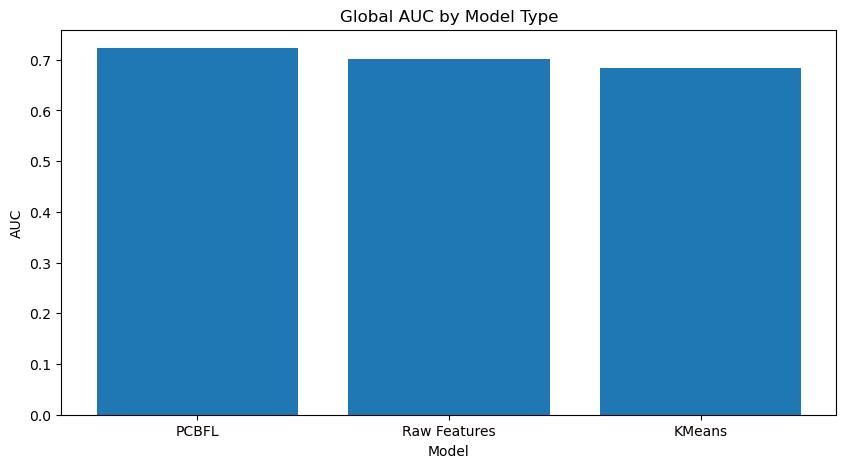

In [50]:
# Ablation results  AUC
categories = ['PCBFL', 'Raw Features', 'KMeans']  
values = [0.7230, 0.7019, 0.6831]  
  
plt.figure(figsize=(10, 5))  
plt.bar(categories, values)  
plt.title('Global AUC by Model Type')  
plt.xlabel('Model')  
plt.ylabel('AUC')    
plt.show()

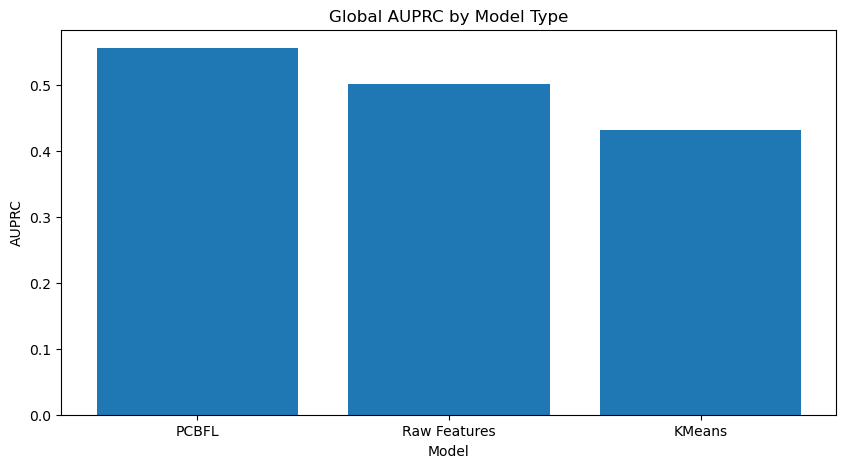

In [51]:
# Ablation results  AUPRC
categories = ['PCBFL', 'Raw Features', 'KMeans'] 
values = [0.5566, 0.5013, 0.4324]  
plt.figure(figsize=(10, 5))  
plt.bar(categories, values)  
plt.title('Global AUPRC by Model Type')  
plt.xlabel('Model')  
plt.ylabel('AUPRC')    
plt.show()

## 5.Discussion

This research aimed to assess the reproducibility of a paper detailing Privacy-preserving Community-Based Federated Learning (PCBFL). The original paper was reproducible. The results of our reproduction effort, though not entirely aligning with the ideal outcomes reported in the original study, provided significant insights into the reproducibility of the paper and highlighted challenges faced during the process. In reproducing the results of the study, the AUC is a little bit lower than what is reported in the original paper (0.72 compared to 0.74) while the AUPRC is a little bit higher than reported (0.56 compared to 0.51).  

We found that our findings were within the same scale as those reported in the original publication. Additionally, when comparing the performance to other models, the results demonstrated general consistency, further validating the reliability of the reported outcomes.

Through ablation study, we also proved the contribution of autoencoder and spectral clustering to the success of the whole framework. PCBFL outperforms versions implemented by directly calculating similarity with raw feature, or replacing spectral clustering with KMeans. Among the two, replacing spectral clustering with KMeans leads to a larger decrease in both metrics, reflecting that the choice of clustering method is more important than the choice of embeddings for similarity calculation. 

What was easy: The paper provided a comprehensive explanation of the PCBFL approach, along with detailed algorithms and pseudocode, which facilitated the understanding of the proposed methodology.

What was difficult: The intergration of the different modules are not so clear. The calculation of the weights based on the cluster results for each sites are not clearly provided. The choice of the hyperparameters as well as the iteration selection are also uncertain. Lastly, it is hard to compare the reproducing results to the original results since the author only provided the figure without the exact numbers in the results.

Suggestions for Improvement: for future reproducibility efforts, it would be beneficial if the authors could provide the detailed setting of the hyperparameters as well as the accurate numbers for the results.

And we also put in a lot of efforts in debugging the official repository provided by the authors. Followings are the three major problems we spotted and fixed:
* In 'server_private.py', the authors claimed two functions with same name 'run_clients', therefore the first one is overwrite by the second one. We changed the first one's name to 'run_clients_autoencoder' and edit the codes wherever this function is meant to be called.
* In 'client_autoencoder.py', the authors forgot to save 'embedding.csv' which is required to be loaded in other python files. Therefore, we have to add the codes for saving the embedding file according to our own understanding.
* One of the hospitals in dataset, 79, has only one remaining patient after preprocessing. With the split of 70-30 and codes implemented by authors, training set contains 0 samples and test set contains only 1 sample. This leads to error in the training stage, therefore we enforced training set and test set containing the same one sample to run the codes.


## 8.References

1.   Elhussein A, Gürsoy G. Privacy-preserving patient clustering for personalized federated learnings[C]//Machine Learning for Healthcare Conference. PMLR, 2023: 150-166.